In [452]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [453]:
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
  
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        return x

class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)
        

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x




In [454]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `Encoder` and `Decoder` class
# load it to the specified device, either gpu or cpu
encoder = Encoder().to(device)
decoder = Decoder().to(device)


# create optimizer objects
# Adam optimizer with learning rate 1e-3
e_optimizer = optim.Adam(encoder.parameters(), lr=1e-3)
d_optimizer = optim.Adam(decoder.parameters(), lr=1e-3)


# mean-squared error loss
criterion = nn.MSELoss()

In [455]:
epochs = 15
mnist_transform = transforms.Compose(
    [transforms.Resize(28), transforms.Grayscale(3), transforms.ToTensor()]
)
svhn_transform = transforms.Compose(
    [transforms.Resize(28), transforms.ToTensor()]
)

In [456]:
mnist_data = datasets.MNIST(root="~/torch_datasets", train=True, download=True, transform=mnist_transform)
svhn_data = datasets.SVHN('train', download=True, transform=svhn_transform)
mnist_loader = DataLoader(mnist_data, batch_size=32, shuffle=True)
svhn_loader = DataLoader(svhn_data, batch_size=32)

Using downloaded and verified file: train/train_32x32.mat


In [457]:

def adaptive_instance_normalization(x, y):
    # standard dev of y * ((x - mean of x)/stddev of y) + mean of y
    return torch.std(y) * ((torch.subtract(x, torch.mean(x)))/torch.std(y)) + torch.mean(y)



In [458]:
for epoch in range(epochs):
    loss = 0
    mnist = iter(mnist_loader)
    svhn = iter(svhn_loader)
    for i in range(1875):
        mnist_feat = next(mnist)[0].to(device)
        svhn_feat = next(svhn)[0].to(device)  
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        e_optimizer.zero_grad()
        d_optimizer.zero_grad()
        
        

        mnist_e = encoder(mnist_feat)
        svhn_e = encoder(svhn_feat)

        adain_layer = adaptive_instance_normalization(mnist_e, svhn_e).to(device)
        
        # compute reconstructions
        outputs = decoder(adain_layer)
        
        # compute training reconstruction loss
        content_loss = criterion(outputs, mnist_feat)
        style_loss = criterion(outputs, svhn_feat)
        train_loss = content_loss + style_loss
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        e_optimizer.step()
        d_optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        
    
    # compute the epoch training loss
    loss = loss / len(mnist_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/15, loss = 0.156756
epoch : 2/15, loss = 0.146153
epoch : 3/15, loss = 0.145584
epoch : 4/15, loss = 0.145154
epoch : 5/15, loss = 0.144982
epoch : 6/15, loss = 0.144771
epoch : 7/15, loss = 0.144648
epoch : 8/15, loss = 0.144573
epoch : 9/15, loss = 0.144523
epoch : 10/15, loss = 0.144373
epoch : 11/15, loss = 0.144415
epoch : 12/15, loss = 0.144331
epoch : 13/15, loss = 0.144267
epoch : 14/15, loss = 0.144272
epoch : 15/15, loss = 0.144252


In [459]:
test_dataset = datasets.MNIST('train', transform=mnist_transform, download=True)
test_loader = DataLoader(
    test_dataset, batch_size=10, shuffle=True
)

test_data = iter(test_loader)
test_examples = None

with torch.no_grad():
  test = next(test_data)[0].to(device)
  test_examples = test.view(-1, 784)
  reconstruction = decoder(encoder(test)).view(-1, 784)
  

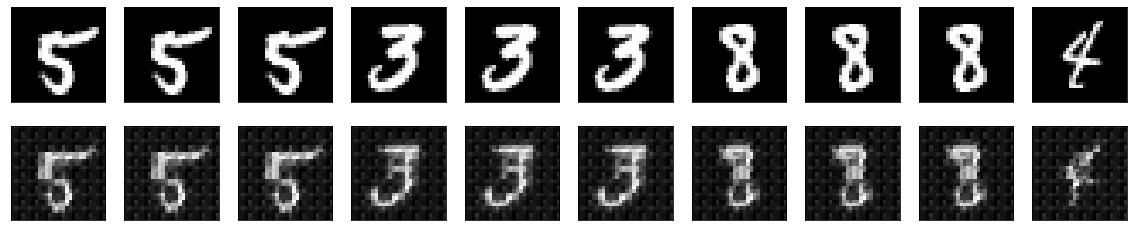

In [460]:
with torch.no_grad():
  number = 10
  plt.figure(figsize=(20, 4))
  for index in range(number):
    # displaying original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #displaying reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()
